## Hackathon 

## Imports

In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
Adam = tf.keras.optimizers.Adam()
BatchNormalization = tf.keras.layers.LayerNormalization
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Conv2D
from sklearn.metrics import confusion_matrix
import itertools
import os
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Path Specification

In [2]:
import os

real = "C:/Users/isack/Desktop/HDL/DL Hackathon files/train/train/training_real/"
fake = "C:/Users/isack/Desktop/HDL/DL Hackathon files/train/train/training_fake/"
datadir = "C:/Users/isack/Desktop/HDL/DL Hackathon files/train/train/"


real_path = os.listdir(real)
fake_path = os.listdir(fake)

### Let's take a closer look.

**1. Real Face**

In [3]:
def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image, (224, 224))
#     print(labels)
    return image[...,::-1]

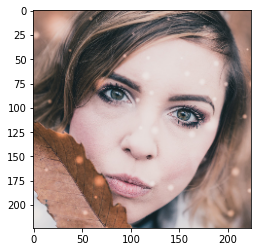

In [4]:
plt.imshow(load_img(real + real_path[2]), cmap='gray')

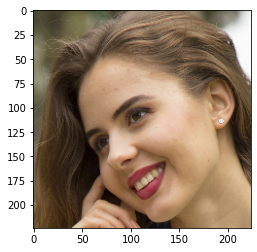

In [5]:
plt.imshow(load_img(real + real_path[20]), cmap='gray')

**2. Fake Face**

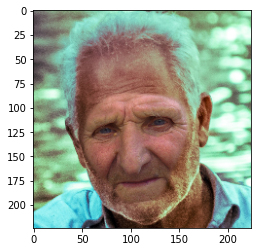

In [6]:
plt.imshow(load_img(fake + fake_path[20]), cmap='gray')

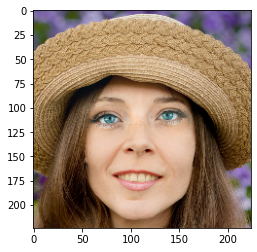

In [7]:
plt.imshow(load_img(fake + fake_path[80]), cmap='gray')

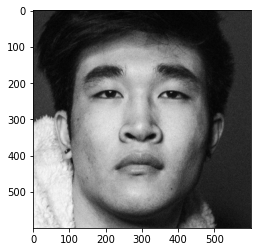

training_real


In [8]:
# datadir = "dataset"
categories = ["training_real" , "training_fake"]

for category in categories:
    path = os.path.join(datadir, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array, cmap="gray")
        # plt.imshow(img_array, cmap= plt.cm.binary)
        plt.show()
        print(category)
        break
    break

### Creating Training Data

In [9]:
training_data = []
IMG_SIZE = 224

## This means 0 will indicate Real facial Images and 1 to Fake facial Images.

categories = ["training_real" , "training_fake"]

def create_training_data():
    for category in categories:
        path = os.path.join(datadir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_UNCHANGED)
                new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                training_data.append([new_array,class_num])
            except:
                pass
create_training_data()


In [10]:
training_data = np.array(training_data)
print(training_data.shape)

(1709, 2)


C:\Users\isack\AppData\Local\Temp/ipykernel_9760/4048587886.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training_data = np.array(training_data)


### Building X(Features) and Y(Labels) for train test split.

### [np.random.shuffle(array)](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.shuffle.html)

- Shuffling here is important as the data is sequential therefore if directly fed into the network, the network just learn to give a single prediction and not on merit. 

In [11]:
import random

np.random.shuffle(training_data)
for sample in training_data[:10]:
    print(sample[1])

0
0
1
1
0
1
1
0
0
0


In [12]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)

In [13]:
print(X.shape)
print(y.shape)

(1709, 224, 224, 3)
(1709,)


In [14]:
print(np.unique(y, return_counts = True))
## (array([0, 1]), array([1081,  960])) This should be the answer

print(y[1:10])

(array([0, 1]), array([949, 760], dtype=int64))
[0 1 1 0 1 1 0 0 0]


In [15]:
## Normalization 
X = X/255.0 

### [Train-Test Split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
print("Shape of train_x: ",X_train.shape)
print("Shape of train_y: ",y_train.shape)
print("Shape of test_x: ",X_test.shape)
print("Shape of test_y: ",y_test.shape)

Shape of train_x:  (1367, 224, 224, 3)
Shape of train_y:  (1367,)
Shape of test_x:  (342, 224, 224, 3)
Shape of test_y:  (342,)


In [18]:
print(y_test[1:10])

[0 0 0 0 1 1 1 1 1]


In [19]:
print(np.unique(y_train, return_counts = True))
print(np.unique(y_test, return_counts = True))

(array([0, 1]), array([769, 598], dtype=int64))
(array([0, 1]), array([180, 162], dtype=int64))


In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D

train_x = tf.keras.utils.normalize(X_train,axis=1)
test_x = tf.keras.utils.normalize(X_test, axis=1)

In [21]:
model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',
                            input_shape= X.shape[1:]),
            tf.keras.layers.Conv2D(64,(3,3),activation = 'relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Conv2D(64,(3,3),activation = 'relu'),
            tf.keras.layers.Conv2D(64,(3,3),activation = 'relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Dropout(0.25),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation=tf.nn.relu),
            tf.keras.layers.Dense(2, activation=tf.nn.softmax)

])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

hist = model.fit(X_train,y_train, batch_size=42, epochs = 50, validation_split=0.1)

Epoch 1/50
30/30 [==============================] - 434s 13s/step - loss: 0.8057 - accuracy: 0.5398 - val_loss: 0.7081 - val_accuracy: 0.5766
Epoch 2/50
30/30 [==============================] - 336s 11s/step - loss: 0.6930 - accuracy: 0.5602 - val_loss: 0.6801 - val_accuracy: 0.5766
Epoch 3/50
30/30 [==============================] - 332s 11s/step - loss: 0.6843 - accuracy: 0.5602 - val_loss: 0.6766 - val_accuracy: 0.5766
Epoch 4/50
30/30 [==============================] - 332s 11s/step - loss: 0.6764 - accuracy: 0.5780 - val_loss: 0.6871 - val_accuracy: 0.5985
Epoch 5/50
30/30 [==============================] - 336s 11s/step - loss: 0.6727 - accuracy: 0.5911 - val_loss: 0.6772 - val_accuracy: 0.5912
Epoch 6/50
30/30 [==============================] - 334s 11s/step - loss: 0.6623 - accuracy: 0.6008 - val_loss: 0.6828 - val_accuracy: 0.6277
Epoch 7/50
30/30 [==============================] - 335s 11s/step - loss: 0.6425 - accuracy: 0.6366 - val_loss: 0.6499 - val_accuracy: 0.6277
Epoch 

### Visualizing Training Loss and Accuracy.

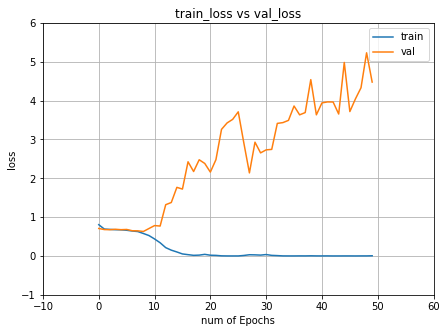

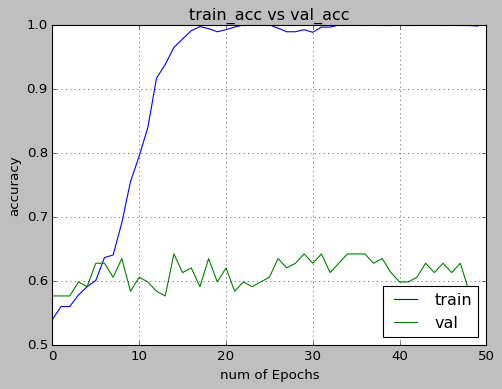

In [22]:
epochs = 50
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

### Evaluation on Test Data

In [23]:
val_loss, val_acc = model.evaluate(X_test, y_test)
print(val_loss)
print(val_acc)

11/11 [==============================] - 17s 1s/step - loss: 5.8570 - accuracy: 0.5585
5.8570027351379395
0.5584795475006104


### Predictions.

In [24]:
predictions = model.predict(X_test)
# predictions

In [25]:
rounded_predictions = model.predict(x = X_test, batch_size=42, verbose=0)
for i in rounded_predictions[:10]:
    print(i)

[1.9950853e-12 1.0000000e+00]
[9.9999988e-01 1.6717841e-07]
[0.28988147 0.7101186 ]
[5.381026e-07 9.999994e-01]
[1.8581924e-04 9.9981421e-01]
[1.0000000e+00 4.6035065e-28]
[2.2515476e-07 9.9999976e-01]
[0.9273132  0.07268676]
[0.99834883 0.00165124]
[9.9946851e-01 5.3156924e-04]


## VGG 16

- Checkout [this](https://neurohive.io/en/popular-networks/vgg16/) article for better Explanation.

In [26]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
Adam = tf.keras.optimizers.Adam()
BatchNormalization = tf.keras.layers.LayerNormalization
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Conv2D
from sklearn.metrics import confusion_matrix
import itertools
import os
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## I don't know why but without running this cell the below code is shown an error. 
## Running all these imports again solved it.
## Will figure out soon.

In [27]:
vgg16_model = keras.applications.vgg16.VGG16()

In [28]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

- **predictions (Dense)          (None, 1000)              4097000**

- Vgg-16 is trained for classification of 1000 different classes, but we do not need that.
- So we will remove that last layer and add one of our own.

In [29]:
type(vgg16_model)
## This is not a sequential model.

keras.engine.functional.Functional

### Customizing our model

In [30]:
from keras.models import Sequential

model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)
    
# Now, we have replicated the entire vgg16_model
# (excluding the output layer) to a new Sequential model, which we've just given the name model

In [31]:
for layer in model.layers:
    layer.trainable = False
    
# Next, we’ll iterate over each of the layers in our new Sequential model and set them to
# be non-trainable. This freezes the weights and other trainable parameters 
# in each layer so that they will not be updated when we pass in our images of fake and real faces.

In [32]:
model.add(Dense(2, activation='softmax'))

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

**Model is Ready, time to Compile it**


In [34]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

hist = model.fit(X_train,y_train, batch_size=42, epochs = 50, #50 
                 validation_split=0.1)

Epoch 1/50
30/30 [==============================] - 458s 12s/step - loss: 0.9264 - accuracy: 0.5179 - val_loss: 0.6995 - val_accuracy: 0.5766
Epoch 2/50
30/30 [==============================] - 354s 12s/step - loss: 0.6979 - accuracy: 0.5382 - val_loss: 0.6891 - val_accuracy: 0.5401
Epoch 3/50
30/30 [==============================] - 355s 12s/step - loss: 0.6804 - accuracy: 0.5764 - val_loss: 0.7186 - val_accuracy: 0.5766
Epoch 4/50
30/30 [==============================] - 353s 12s/step - loss: 0.6682 - accuracy: 0.5813 - val_loss: 0.6919 - val_accuracy: 0.5547
Epoch 5/50
30/30 [==============================] - 351s 12s/step - loss: 0.6646 - accuracy: 0.6220 - val_loss: 0.6969 - val_accuracy: 0.5620
Epoch 6/50
30/30 [==============================] - 353s 12s/step - loss: 0.6606 - accuracy: 0.6098 - val_loss: 0.6696 - val_accuracy: 0.5328
Epoch 7/50
30/30 [==============================] - 354s 12s/step - loss: 0.6854 - accuracy: 0.5837 - val_loss: 0.7168 - val_accuracy: 0.5328
Epoch 

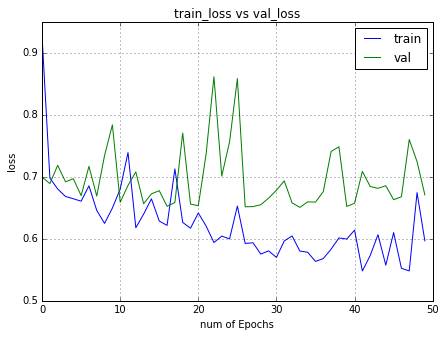

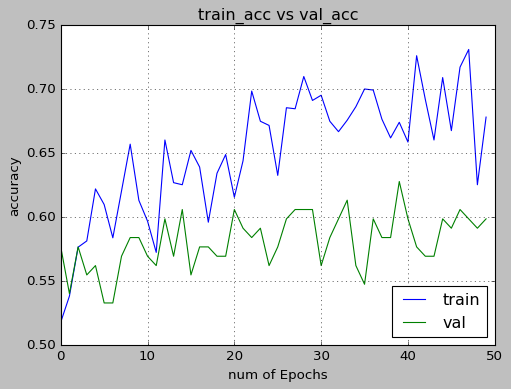

In [35]:
#50
epochs = 50
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

In [36]:
val_loss, val_acc = model.evaluate(X_test, y_test)
print(val_loss)
print(val_acc)

11/11 [==============================] - 89s 8s/step - loss: 0.7125 - accuracy: 0.5731
0.7125415802001953
0.5730994343757629


In [37]:
predictions = model.predict(X_test)
# predictions

In [38]:
rounded_prediction = model.predict(x = X_test, batch_size=42, verbose=0)
for i in rounded_predictions[:10]:
    print(i)

[1.9950853e-12 1.0000000e+00]
[9.9999988e-01 1.6717841e-07]
[0.28988147 0.7101186 ]
[5.381026e-07 9.999994e-01]
[1.8581924e-04 9.9981421e-01]
[1.0000000e+00 4.6035065e-28]
[2.2515476e-07 9.9999976e-01]
[0.9273132  0.07268676]
[0.99834883 0.00165124]
[9.9946851e-01 5.3156924e-04]


In [39]:
print(y_test[1:10])
print(np.unique(y_test, return_counts = True))

[0 0 0 0 1 1 1 1 1]
(array([0, 1]), array([180, 162], dtype=int64))


In [40]:
rounded_prediction = np.array(rounded_prediction)
print(np.unique(rounded_prediction, return_counts = True))

(array([0.01705235, 0.02272248, 0.04095314, 0.0452214 , 0.04610343,
       0.04633025, 0.04706052, 0.0474893 , 0.04805462, 0.04870418,
       0.04990701, 0.05591301, 0.05737174, 0.06401844, 0.06481835,
       0.06982582, 0.07317635, 0.07391775, 0.07427491, 0.07728721,
       0.08259204, 0.08639242, 0.08701781, 0.08842066, 0.09047647,
       0.09191143, 0.09450898, 0.09541842, 0.09773232, 0.10000619,
       0.10023275, 0.10062306, 0.1006868 , 0.10171564, 0.10256875,
       0.10686532, 0.10720155, 0.11070451, 0.11192245, 0.11384742,
       0.11623699, 0.11666065, 0.11950745, 0.11984902, 0.12348431,
       0.12865546, 0.13275635, 0.13321897, 0.13415717, 0.13759774,
       0.13794614, 0.14279088, 0.14346457, 0.14406225, 0.14415969,
       0.14479958, 0.14745304, 0.14795311, 0.14893994, 0.14953138,
       0.1525095 , 0.15407312, 0.15734616, 0.15817007, 0.1600976 ,
       0.16063923, 0.16134436, 0.16485077, 0.1667626 , 0.16972084,
       0.17036673, 0.1731867 , 0.17404486, 0.17636673, 0.1767

## Predictions vs Actual.

In [41]:
## Just Run this once and you can change the number of the images mentioned for prediction and model result.

## For Image Display.
def load_img(path):
    image = cv2.resize(path, (224, 224))
    return image[...,::-1]

## For Predicting result.
def prepare(image):
    IMG_SIZE = 224
    new_array = cv2.resize(image, (IMG_SIZE, IMG_SIZE)) 
    return new_array.reshape(-1, IMG_SIZE,IMG_SIZE,3)

## 0 is Real Face
## 1 is Fake Face


In [42]:
testImgpath = 'C:/Users/isack/Desktop/HDL/DL Hackathon files/test/test'

In [43]:
test_data=[]
IMG_SIZE=224

def create_test_data():
    for img in os.listdir(testImgpath):
        #print(img)
        img_array=cv2.imread(os.path.join(testImgpath,img), cv2.IMREAD_UNCHANGED)
        new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
        test_data.append(new_array)
create_test_data()

In [44]:
predictions = model.predict(np.array(test_data))
ppredictions = [round(x[0]) for x in predictions]
print(ppredictions)

[0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]


In [45]:
import pandas as pd 
sample_df = pd.read_csv('sample_submission.csv')
sample_df.head(2)

,file_id,label
0,0,NaN
1,1,NaN


In [46]:
sample_df['label'] = ppredictions
sample_df.to_csv('Isac_2.csv', index=False)

Probabilities:  [[0.5286666  0.47133338]]
Actual:  Fake-Face
Prediction:  Fake-Face


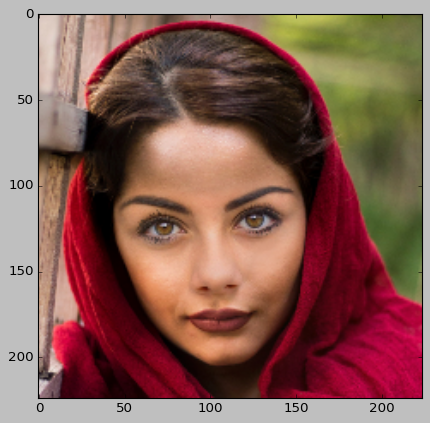

In [47]:
## Change the value of n for other images. I have chosen these images randomly.

n = 0

prediction = model.predict(prepare(X_test[n]))
print("Probabilities: ",prediction)

x = ["Real-Face" if y_test[n]== 0 else "Fake-Face"]
print("Actual: ",x[0])

rounded_prediction = model.predict(x = prepare(X_test[n]), batch_size=42, verbose=0)

y = ["Real-Face" if rounded_prediction.all()== 0 else "Fake-Face"]
print("Prediction: ", y[0])

plt.imshow(load_img(X_test[n]), cmap='gray')
plt.show()

Probabilities:  [[0.35143393 0.64856607]]
Actual:  Real-Face
Prediction:  Real-Face


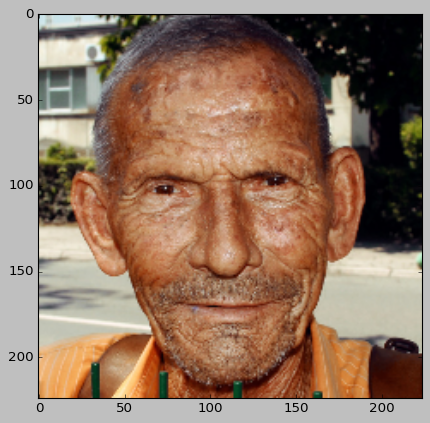

In [48]:
n = 120

prediction = model.predict(prepare(X_test[n]))
print("Probabilities: ",prediction)

x = ["Real-Face" if y_test[n]== 0 else "Fake-Face"]
print("Actual: ",x[0])

rounded_prediction = model.predict(x = prepare(X_test[n]), batch_size=42, verbose=0)

y = ["Real-Face" if ppredictions[n]== 0 else "Fake-Face"]
print("Prediction: ", y[0])

plt.imshow(load_img(X_test[n]), cmap='gray')
plt.show()

Probabilities:  [[0.34175175 0.65824825]]
Actual:  Fake-Face
Prediction:  Fake-Face


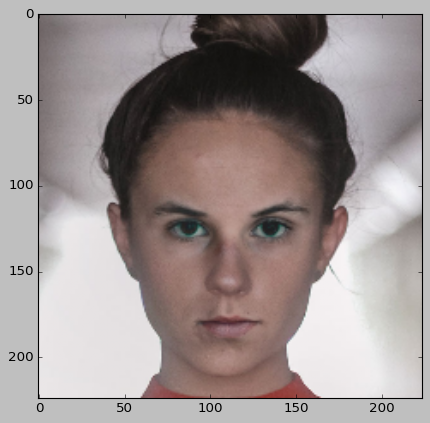

In [49]:
n = 41

prediction = model.predict(prepare(X_test[n]))
print("Probabilities: ",prediction)

x = ["Real-Face" if y_test[n]== 0 else "Fake-Face"]
print("Actual: ",x[0])

rounded_prediction = model.predict(x = prepare(X_test[n]), batch_size=42, verbose=0)

y = ["Real-Face" if ppredictions[n]== 0 else "Fake-Face"]
print("Prediction: ", y[0])

plt.imshow(load_img(X_test[n]), cmap='gray')
plt.show()

Probabilities:  [[0.70448613 0.29551387]]
Actual:  Real-Face
Prediction:  Real-Face


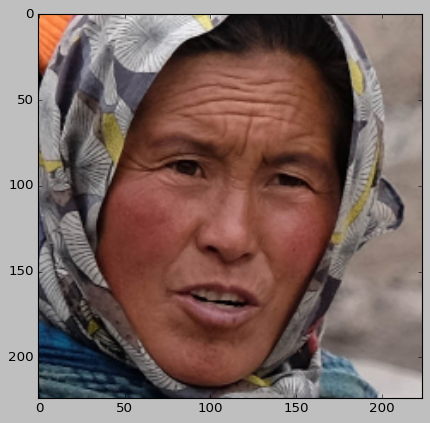

In [50]:
n = 140

prediction = model.predict(prepare(X_test[n]))
print("Probabilities: ",prediction)

x = ["Real-Face" if y_test[n]== 0 else "Fake-Face"]
print("Actual: ",x[0])

rounded_prediction = model.predict(x = prepare(X_test[n]), batch_size=42, verbose=0)

y = ["Real-Face" if ppredictions[n]== 0 else "Fake-Face"]
print("Prediction: ", y[0])

plt.imshow(load_img(X_test[n]), cmap='gray')
plt.show()

Probabilities:  [[0.7422041  0.25779587]]
Actual:  Real-Face
Prediction:  Real-Face


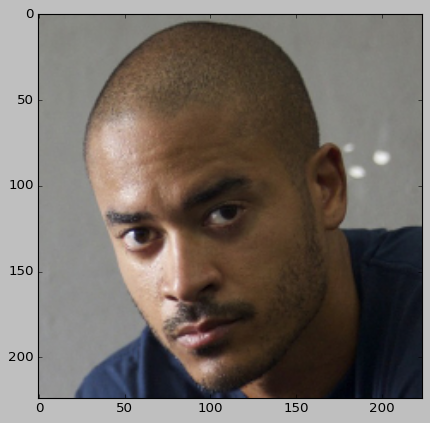

In [51]:
n = 162

prediction = model.predict(prepare(X_test[n]))
print("Probabilities: ",prediction)

x = ["Real-Face" if y_test[n]== 0 else "Fake-Face"]
print("Actual: ",x[0])

rounded_prediction = model.predict(x = prepare(X_test[n]), batch_size=42, verbose=0)

y = ["Real-Face" if ppredictions[n]== 0 else "Fake-Face"]
print("Prediction: ", y[0])

plt.imshow(load_img(X_test[n]), cmap='gray')
plt.show()

Probabilities:  [[0.738527 0.261473]]
Actual:  Real-Face
Prediction:  Real-Face


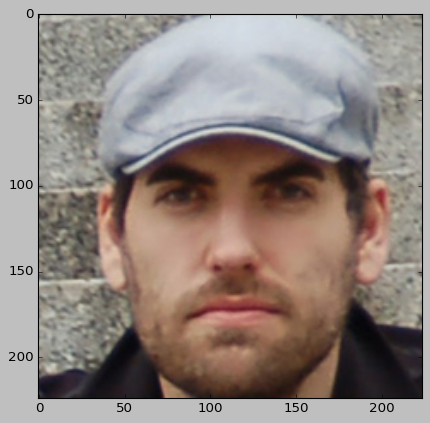

In [52]:
n = 16

prediction = model.predict(prepare(X_test[n]))
print("Probabilities: ",prediction)

x = ["Real-Face" if y_test[n]== 0 else "Fake-Face"]
print("Actual: ",x[0])

rounded_prediction = model.predict(x = prepare(X_test[n]), batch_size=42, verbose=0)

y = ["Real-Face" if ppredictions[n]== 0 else "Fake-Face"]
print("Prediction: ", y[0])

plt.imshow(load_img(X_test[n]), cmap='gray')
plt.show()

In [ ]:
n = 101

prediction = model.predict(prepare(X_test[n]))
print("Probabilities: ",prediction)

x = ["Real-Face" if y_test[n]== 0 else "Fake-Face"]
print("Actual: ",x[0])

rounded_prediction = model.predict(x = prepare(X_test[n]), batch_size=42, verbose=0)

y = ["Real-Face" if ppredictions[n]== 0 else "Fake-Face"]
print("Prediction: ", y[0])

plt.imshow(load_img(X_test[n]), cmap='gray')
plt.show()

Probabilities:  [[0.6327568 0.3672431]]
Actual:  Fake-Face
Prediction:  Real-Face


In [ ]:
n = 201

prediction = model.predict(prepare(X_test[n]))
print("Probabilities: ",prediction)

x = ["Real-Face" if y_test[n]== 0 else "Fake-Face"]
print("Actual: ",x[0])

rounded_prediction = model.predict(x = prepare(X_test[n]), batch_size=42, verbose=0)

y = ["Real-Face" if ppredictions[n]== 0 else "Fake-Face"]
print("Prediction: ", y[0])

plt.imshow(load_img(X_test[n]), cmap='gray')
plt.show()

In [ ]:
n = 332

prediction = model.predict(prepare(X_test[n]))
print("Probabilities: ",prediction)

x = ["Real-Face" if y_test[n]== 0 else "Fake-Face"]
print("Actual: ",x[0])

rounded_prediction = model.predict(x = prepare(X_test[n]), batch_size=42, verbose=0)

y = ["Real-Face" if ppredictions[n]== 0 else "Fake-Face"]
print("Prediction: ", y[0])

plt.imshow(load_img(X_test[n]), cmap='gray')
plt.show()

In [ ]:
n = 171

prediction = model.predict(prepare(X_test[n]))
print("Probabilities: ",prediction)

x = ["Real-Face" if y_test[n]== 0 else "Fake-Face"]
print("Actual: ",x[0])

rounded_prediction = model.predict(x = prepare(X_test[n]), batch_size=42, verbose=0)

y = ["Real-Face" if ppredictions[n]== 0 else "Fake-Face"]
print("Prediction: ", y[0])

plt.imshow(load_img(X_test[n]), cmap='gray')
plt.show()